s216169, Magnus Bengtsson

s194268, Anton Jørgensen

Group 32

# Exercise 1

## In this exercise you should implement everything including the tests (e.g. the chi-square and KS tests) yourself. Later, when your code is working you are free to use builtin functions.

## 1. Write a program implementing a linear congruential generator (LCG). Be sure that the program works correctly using only integer representation

### (a) Generate 10.000 (pseudo-) random numbers and present these numbers in a histogramme (e.g. 10 classes).

We write a LCG that can only take integer values. It is defined by:
$$
X_{n+1} = (aX_n+c)\mod M
$$
Here, $a$ is the multiplier, $c$ is the shift, and $M$ is the modulus. 

We initialize the algorithm by setting $X_0 = 2^{30} - 1$, the multiplier $a=48271$, the shift $c=0$, and the modulus $M=2^{31} - 1$. 

Thus, we can generate 10000 pesuodo-random numbers.

In [54]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from scipy.stats import chisquare, kstest
from statsmodels.sandbox.stats.runs import runstest_1samp
np.random.seed(1234)

def linear_congruential(x0, multiplier, shift, modulus, n=10000, to_unit_interval=True):
    xs = np.empty(n + 1)
    xs[0] = x0
    for i in range(1, n + 1):
        xs[i] = (multiplier * xs[i - 1] + shift) % modulus

    if to_unit_interval:
        return xs[1:] / modulus
    return xs[1:]

values = linear_congruential(2**30 - 1, 48271, 0, 2 ** 31 - 1)
values

array([0.49998876, 0.95748378, 0.6993237 , ..., 0.90753563, 0.65215983,
       0.40703805])

We construct a histogram and a scatterplot of the values. This helps reveal any potential patterns or correlations between consecutive numbers, which would indicate poor randomness.

This shows a reasonably uniform spread of points across the unit square, albeit definitely some reoccurence, i.e., a short cycle.

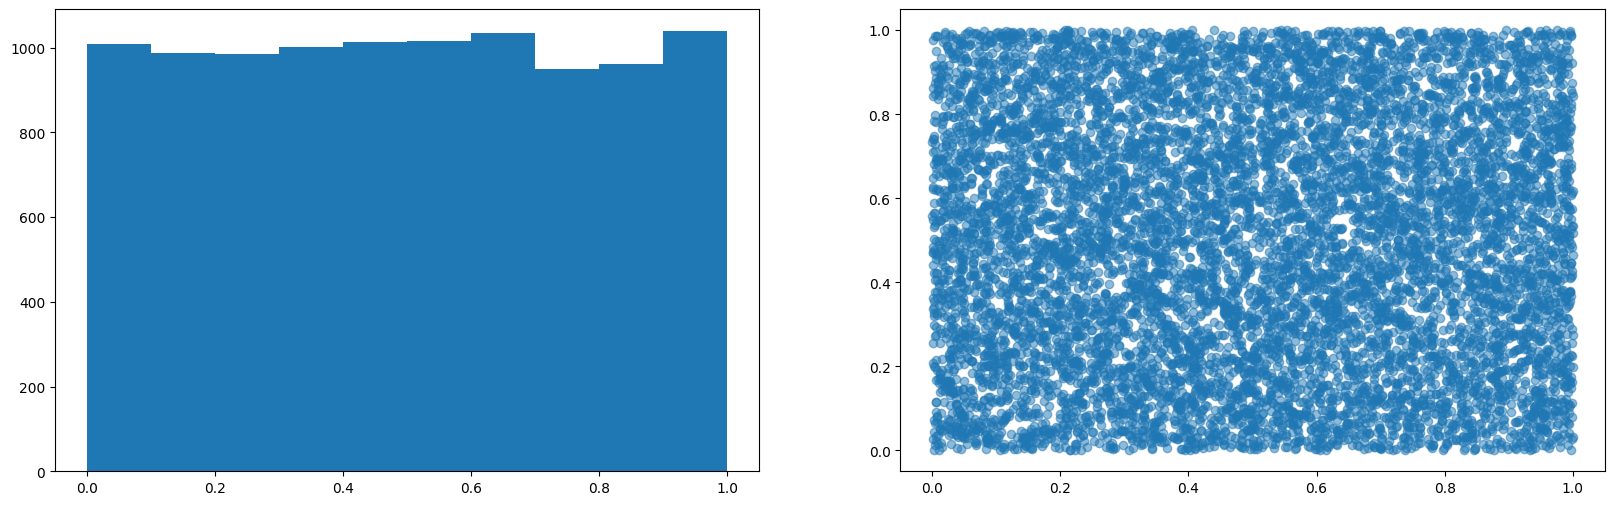

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.hist(values)
ax2.scatter(values[:-1], values[1:], alpha=0.5)

### (b) Evaluate the quality of the generator by descriptive statistics (histogrammes, scatter plots) and statistical tests - χ2, Kolmogorov-Smirnov, run-tests, andcorrelation test.

To assess whether the values generated by the LCG are uniformly distributed, a chi-square goodness-of-fit test is done. Here, 10 classes is used.

In [56]:
num_bins = 10
observed_counts, _ = np.histogram(values, bins=num_bins)
expected_counts = np.full(num_bins, len(values) / num_bins)
T = sum((obs - exp)**2 / exp for obs, exp in zip(observed_counts, expected_counts))
chi2_stat, p_val_chi2 = chisquare(f_obs=observed_counts, f_exp=expected_counts)

print(f"Chi-square T = {T:.4f}, p-value = {p_val_chi2:.10f}")

Chi-square T = 7.5800, p-value = 0.5769614410


Here, we see the p-value of 0.58 is obtained, meaning the null hypothesis cannot be discarded of not an uniform distribution. Thus, the numbers from the LFG generated do suggest to follow an Uniform distribution.

To further evaluate the uniformity of the numbers, the Kolmogorov-Smirnov test is also applied:

In [58]:
ks_stat, p_val_ks = kstest(values, 'uniform')
print(f"KS statistic = {ks_stat:.4f}, p-value = {p_val_ks:.10f}")

KS statistic = 0.0062, p-value = 0.8408147458


Since the p-value is 0.84, we again cannot reject the nul hypothesis. Thus, the generated values do follow an uniform distribution with the chosen parameters.

Now, a run test is done, as to assess if the sequence of values generated by the LCG has an abnormal amount of runs, suggesting if there is or is not randomness in the number sequence.

In [59]:
median = np.median(values)
binary_seq = np.where(values > median, 1, 0)
z_stat, p_val_run = runstest_1samp(binary_seq)
print(f"Run test z = {z_stat:.4f}, p-value = {p_val_run:.4f}")

Run test z = -0.6000, p-value = 0.5485


Again, the the null hypothesis cannot be discarded, meaning the generated number sequence exhibits a random structure. 

To check whether the generated values are independent of each other, we calculate the lag-1 correlation - the correlation between $U[i]$ and $U[i+1]$:

In [60]:
u1 = values[:-1]
u2 = values[1:]
correlation = np.corrcoef(u1, u2)[0, 1]
print(f"Lag-1 correlation = {correlation:.4f}")

Lag-1 correlation = -0.0030


A correlation of -0.003 suggests almost none of a correlation between units. This suggests that the generator generates numbers that are (almost) independent of the previous number in the sequence, ideal for a random number generator.

### (c) Repeat (a) and (b) by experimenting with different values of “a”, “b” and “M”. In the end you should have a decent generator. Report at least one bad and your final choice.

To identify a good combination of parameters $a$, $b$, and $M$ for the LCG, multiple configurations are now evaluated, testing them for uniformity and randomness. 

Here, a despicable choice is presented, where $X_0 = 3$, $a=1$, $c=0$, $M=2$:

In [ ]:
test1 = linear_congruential(3, 1, 0, 2) 
test1

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

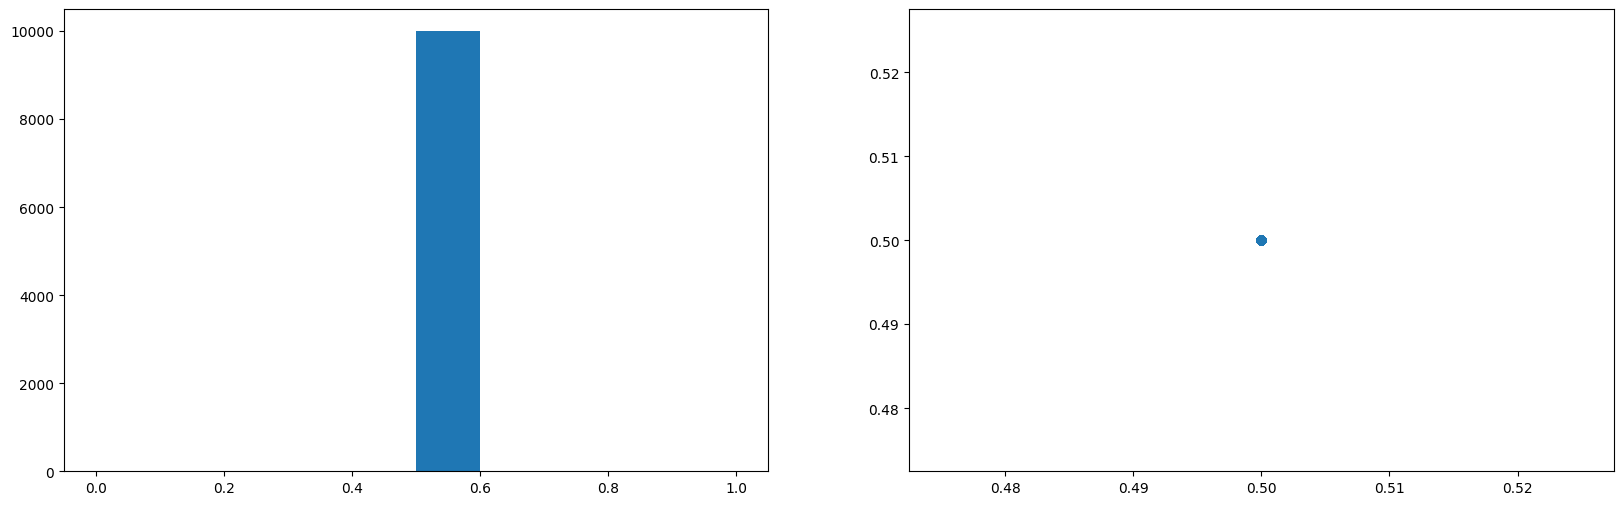

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.hist(test1)
ax2.scatter(test1[:-1], test1[1:], alpha=0.5)

The histogram shows only one bar, meaning all 10,000 values are the same (as can also be seen from the print earlier). Furthermore, every point in the scatterplot is in the same location, indicating no randomness.

Just from observing these two plots, it can be concluded that this configuration is a despicable choice if randomness was desired.

Moving on to the good case, where $a=16807$, $c=0$, $M=2^{31}-1$. Specifically, this configuration is known as the Park–Miller LCG:

In [76]:
test2 = linear_congruential(48271, 16807, 0, 2**31 - 1)  
test2

array([0.37778667, 0.46057146, 0.82450768, ..., 0.82405734, 0.93177724,
       0.38008405])

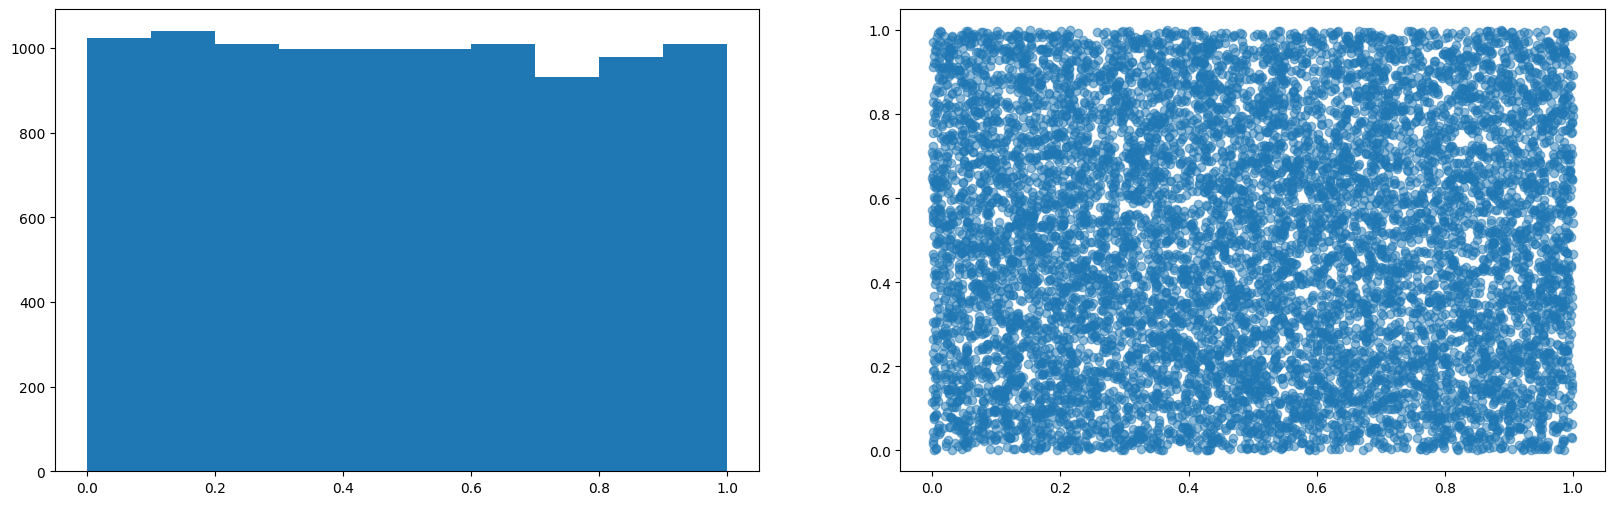

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.hist(test2)
ax2.scatter(test2[:-1], test2[1:], alpha=0.5)

Here, the histogram shows that the values are evenly distributed. Additionally, the scatter plot indicate no visible patterns, which is also to be expected as this configuration has a really long cycle of $M-1$.

Now for the tests:

In [79]:
num_bins = 10
observed_counts, _ = np.histogram(test2, bins=num_bins)
expected_counts = np.full(num_bins, len(test2) / num_bins)
T = sum((obs - exp)**2 / exp for obs, exp in zip(observed_counts, expected_counts))
chi2_stat, p_val_chi2 = chisquare(f_obs=observed_counts, f_exp=expected_counts)

print(f"Chi-square T = {T:.4f}, p-value = {p_val_chi2:.10f}")

ks_stat, p_val_ks = kstest(test2, 'uniform')
print(f"KS statistic = {ks_stat:.4f}, p-value = {p_val_ks:.10f}")

median = np.median(test2)
binary_seq = np.where(test2 > median, 1, 0)
z_stat, p_val_run = runstest_1samp(binary_seq)
print(f"Run test z = {z_stat:.4f}, p-value = {p_val_run:.4f}")

u1 = test2[:-1]
u2 = test2[1:]
correlation = np.corrcoef(u1, u2)[0, 1]
print(f"Lag-1 correlation = {correlation:.4f}")

Chi-square T = 7.3980, p-value = 0.5957556091
KS statistic = 0.0111, p-value = 0.1680999053
Run test z = 0.0800, p-value = 0.9362
Lag-1 correlation = -0.0034


The $\chi^2$-test shows a high p-valuem, meaning the generated values do follow an Uniform distribution. Furthermore, the KS-statistic also shows a high p-value. The run test also shows a very high p-value, meaning the generated numbers follow "randomness". Finally, the lag-1 correlation shows that there is a very miniscule correlation between consequtive numbers in the sequence. 

Overall, the generator appears to produce random, independent values.

### 2. Apply a system available generator and perform the various statistical tests you did under Part 1 point (b) for this generator too.

Here, 10000 values are generated using NumPy’s built-in random number generator and evaluated for statistical quality. Specifically, 10.000 random values are generated, where $X\sim\text{Uniform}(0,1)$:

Chi-square T = 12.9860, p-value = 0.1632407713
KS statistic = 0.0075, p-value = 0.6178824245
Run test z   = -0.7200, p-value = 0.4715
Lag-1 correlation = 0.0042


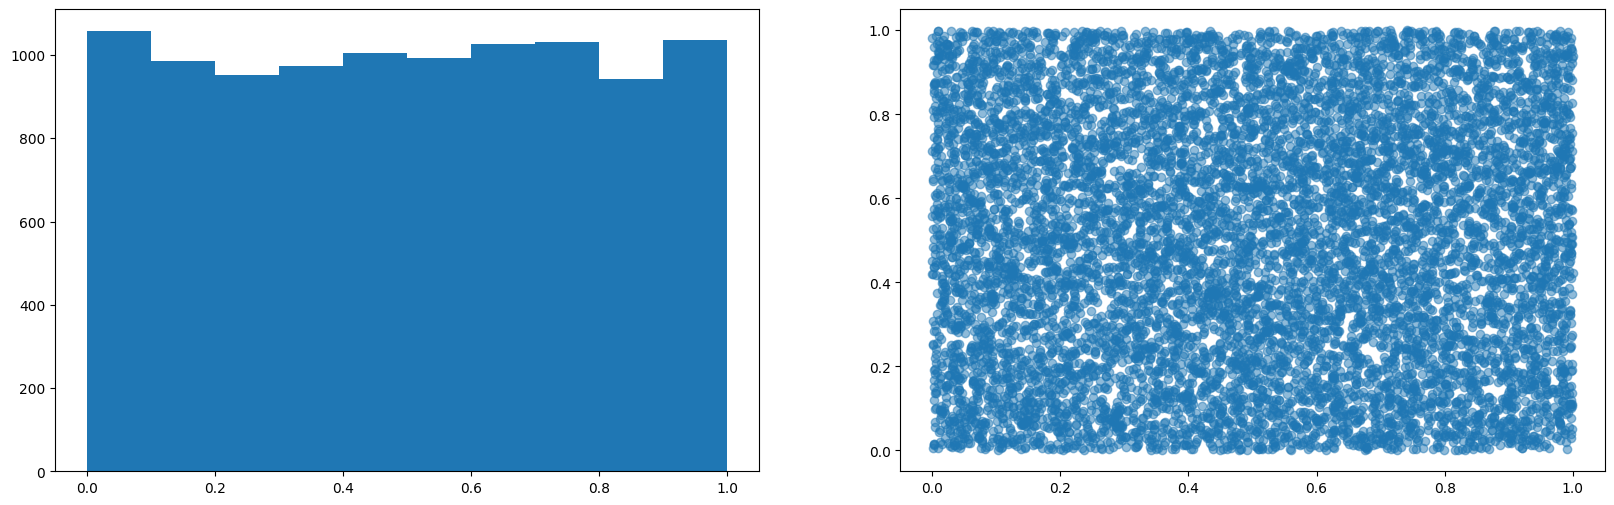

In [81]:
values = np.random.uniform(0, 1, 10000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.hist(values)
ax2.scatter(values[:-1], values[1:], alpha=0.5)

num_bins = 10
observed_counts, _ = np.histogram(values, bins=num_bins)
expected_counts = np.full(num_bins, len(values) / num_bins)
T = sum((obs - exp)**2 / exp for obs, exp in zip(observed_counts, expected_counts))
chi2_stat, p_val_chi2 = chisquare(f_obs=observed_counts, f_exp=expected_counts)
ks_stat, p_val_ks = kstest(values, 'uniform')
median = np.median(values)
binary_seq = np.where(values > median, 1, 0)
z_stat, p_val_run = runstest_1samp(binary_seq)
u1 = values[:-1]
u2 = values[1:]
correlation = np.corrcoef(u1, u2)[0, 1]

print(f"Chi-square T = {T:.4f}, p-value = {p_val_chi2:.10f}")
print(f"KS statistic = {ks_stat:.4f}, p-value = {p_val_ks:.10f}")
print(f"Run test z   = {z_stat:.4f}, p-value = {p_val_run:.4f}")
print(f"Lag-1 correlation = {correlation:.4f}")

The histogram shows an even distribution, indicating good uniformity, while the scatter plot reveals no visible patterns, suggesting independence.

The Chi-square shows a p-value of approximately 0.16, indicating no significant deviation from the expected uniform distribution. Similarly, KS test yields a high p-value of 0.61, further supporting the hypothesis that the values are uniformly distributed over the interval [0,1].

The run test shows a p-value of 0.47, suggesting that the sequence does exhibit randomness.

The lag-1 correlation is very close to 0, confirming the lack of correlation between successive values and indicating strong independence.

Despite minor fluctuations expected in limited samples ($n=10000$), the overall results show excellent statistical behavior from the system's built-in random number generator. It passes all basic tests of uniformity, independence, and randomness.

It is therefore considered suitable for use in simulation and statistical applications.

### 3. You were asked to simulate one sample and perform tests on this sample. Discuss the sufficiency of this approach and take action, if needed.

I think testing just one sample can give a general idea of how good the generator is, but it’s probably not enough on its own. Since random variation can affect the outcome, a single test might not reflect the generator’s actual behavior. To be more confident, I tried generating and testing multiple samples. The results were consistent across runs which made me feel more sure that the generator is performing reliably and that the earlier results were not just "random" strokes of luck.